# 5. Compositional Tracking

This notebook demonstrates the compositional tracking capabilities in TriPoD, which allows you to track multiple chemical species through gas and dust phases including sublimation and condensation processes.

TriPoD extends the basic dust evolution framework to include:
- Multiple chemical components with distinct properties
- Gas and dust phases for each component
- Sublimation and condensation processes

## Theory

This means under the hood Tripod evolves all the gas components and sums them up to get the total gas surface density. We do this following the works of ([Pavlyuchenkov and C. P. Dullemond 2007](http://www.aanda.org/10.1051/0004-6361:20077317)) who showed that we can decompose the evolution of gas disk into its components as follows:

\begin{equation}
\frac{\partial \Sigma_i}{\partial t}
+ \frac{1}{R} \frac{\partial}{\partial R} (R \Sigma_i v_R)
= \frac{3}{R} \frac{\partial}{\partial R} \left[ R \nu \Sigma \frac{\partial}{\partial R} \left( \frac{\Sigma_i}{\Sigma} \right) \right].
\end{equation}

where the velocit is given by:

\begin{equation}
v_R = -\frac{3}{\Sigma \sqrt{R}} \frac{\partial}{\partial R} \left( \Sigma \nu \sqrt{R} \right).
\end{equation}

and $\Sigma = \sum_i \Sigma_i$  


for active dust components we follow ([Schneider & Bitsch 2021](http://arxiv.org/abs/2105.13267)) i.e. the dust evolution can be described by if there are mutiple com ponents present:

\begin{equation}
\frac{\partial \Sigma_{d,i,j}}{\partial t} + \frac{1}{r} \frac{\partial}{\partial r} \left\{ r \left[ \Sigma_{d,i,j} \cdot u_{d,j} - \frac{\partial}{\partial r} \left( \frac{\Sigma_{d,i,j}}{\Sigma_{\text{gas}}} \right) \cdot \Sigma_{\text{gas}} \nu \right] \right\} = \frac{\partial \Sigma_{d,i,j}}{\partial t}\vert_{coag}
\end{equation}

where the velocities are acalcualted for the total dust with

\begin{equation}
\rho_s = \sum_i \Sigma_i /(\sum_i \Sigma_i/\rho_{s,i})
\end{equation}

and the coagualtion source term is defiend by:

\begin{equation}
\dot{\Sigma}_{i,0 \rightarrow 1} = \frac{\Sigma_{i,0} \Sigma_1 \sigma_{01} \Delta v_{01}}{m_1 \sqrt{2\pi(H_0^2 + H_1^2)}}, etc.
\end{equation}

which esures all of the species exchange mass on the same timescale.



lastly we have to over how the equilibration between the dust and gas phase works if we have a species that is active in both:

the sublimation of a specific species is given by:

and the condensation is given by:

where A is the total surface area the vapour acn condese onto a d nu, and T are meterial parameters specific to the component.

## Setting Up a Simulation with Components

Let's start by importing the necessary modules and creating a simulation object.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tripod
import dustpy.constants as c

# Create simulation object
sim = tripod.Simulation()

# Basic setup
sim.ini.grid.Nr = 50
sim.ini.grid.rmin = 1.0 * c.au
sim.ini.grid.rmax = 1000.0 * c.au

# Initialize the simulation
sim.initialize()

## Default Components

By default, TriPoD creates one gas component with the desired mean molecular weight and surface desity profile form the input:

In [11]:
# List all components
print("Available components:")
for name in sim.components.__dict__.keys():
    if not name.startswith('_'):
        comp = sim.components.__dict__[name]
        print(f"  {name}: {comp.description}")

Available components:
  Default: Atomic heliumDefault (dust_tracer=False, gas_active=True, gas_tracer=False)


Each component can have one of several different beaviours:

-   it can be a tracer in the dust or the gas (if there are mutiple components available for the restpective field the tracer follows the global evolution)

- it can be active in the dust or gas and thus contributes to the golobal evolution of the corresponing field (we follow the derrivations of  ([Pavlyuchenkov and C. P. Dullemond 2007](http://www.aanda.org/10.1051/0004-6361:20077317)) for the gas and ([Schneider & Bitsch 2021](http://arxiv.org/abs/2105.13267)) paper for the dust)

- it can be active both in  the dust and gas and will equilibrate acoording to the sublimation condesation equilibrium 


## Adding Custom Components

Let's show how to add the different types of components to the simulation

### TRACERS 

below we set up a example simualtion with a gas and dust tracer with a step function and let it be advected by the corresponding fluid

In [12]:
sim.t.snapshots = np.linspace(0,1e6*c.year,20)

tr = np.ones_like(sim.grid.r)*1e-5
tr[sim.grid.r<10*c.au] = 1.0
trd = tr[:,None]*np.ones_like(sim.dust.Sigma)
sim.writer.overwrite = True
sim.addcomponent_c("tr",tr,0.32,gas_tracer=True)
sim.addcomponent_c("trd",tr,0.32,dust_value=trd,dust_tracer=True)


In [13]:
lsttr = []
lsttrd = []
sim.addgroup("plot", description="Plot parameters")
sim.plot.addfield("ex", "plasma", description="Colormap for gas tracer")

def update_plot(sim):
    plt.figure(figsize=(8,6))
    plt.plot(sim.grid.r/c.au, sim.components.tr.gas.value)
    plt.xscale("log")
    plt.show()
    plt.close()
    
def up(sim):
    lsttr.append(sim.components.tr.gas.value.copy())
    lsttrd.append(sim.components.trd.dust.value.copy())

sim.plot.ex.updater = up
sim.plot.updater = ["ex"]
list =  sim.updateorder 
sim.updater = list + ["plot"]

In [14]:
sim.run()


TriPoD v0.0.1

Writing file data/data0000.hdf5
Writing dump file data/frame.dmp
Writing file data/data0001.hdf5
Writing dump file data/frame.dmp
Writing file data/data0002.hdf5
Writing dump file data/frame.dmp
Writing file data/data0003.hdf5
Writing dump file data/frame.dmp
Writing file data/data0004.hdf5
Writing dump file data/frame.dmp
Writing file data/data0005.hdf5
Writing dump file data/frame.dmp
Writing file data/data0006.hdf5
Writing dump file data/frame.dmp
Writing file data/data0007.hdf5
Writing dump file data/frame.dmp
Writing file data/data0008.hdf5
Writing dump file data/frame.dmp
Writing file data/data0009.hdf5
Writing dump file data/frame.dmp
Writing file data/data0010.hdf5
Writing dump file data/frame.dmp
Writing file data/data0011.hdf5
Writing dump file data/frame.dmp
Writing file data/data0012.hdf5
Writing dump file data/frame.dmp
Writing file data/data0013.hdf5
Writing dump file data/frame.dmp
Writing file data/data0014.hdf5
Writing dump file data/frame.dmp
Writing f

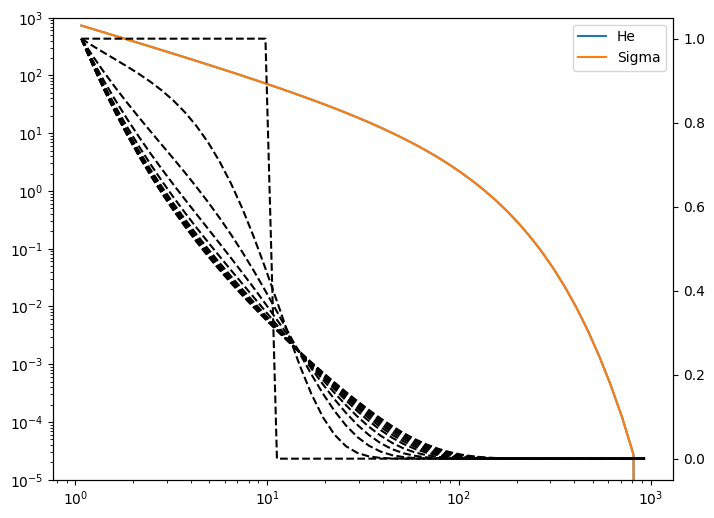

In [15]:
plt.figure(figsize=(8,6))
#plt.plot(sim.grid.r/c.au, sim.components.H2.gas.Sigma, label="H2")
#plt.plot(sim.grid.r/c.au, sim.components.He.gas.Sigma, label="He")
plt.plot(sim.grid.r/c.au, sim.components.Default.gas.Sigma, label="He")
#plt.plot(sim.grid.r/c.au, data.components.Default.gas, label="He")

plt.plot(sim.grid.r/c.au, sim.gas.Sigma, label="Sigma")
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-5, 1e3)
plt.legend()
ax2 = plt.twinx()


for i in range(len(lsttr))[::len(lsttr)//10]:
    ax2.plot(sim.grid.r/c.au, lsttr[i],"k--" ,label="Tracer")

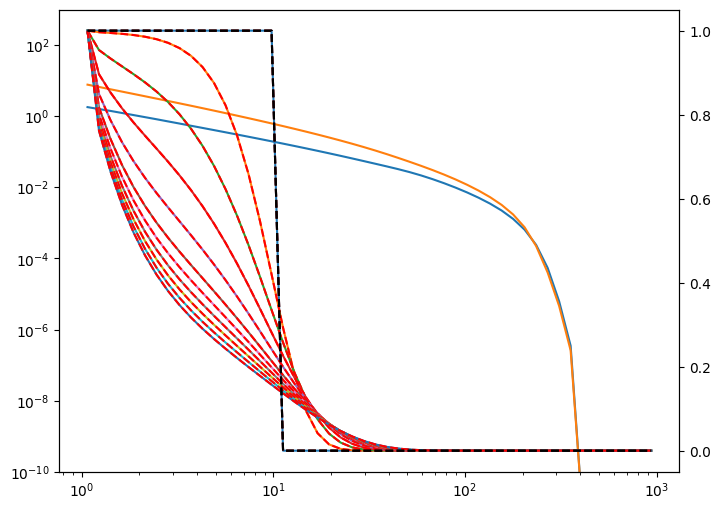

In [16]:
plt.figure(figsize=(8,6))
plt.plot(sim.grid.r/c.au, sim.dust.Sigma, label="Dust")
#plt.plot(sim.grid.r/c.au, sim.dust.Sigma.sum(-1), label="Dust")
#plt.plot(sim.grid.r/c.au, data.dust.Sigma[0,...], label="Dust")

plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-10, 1e3)
ax2 = plt.twinx()


for i in range(len(lsttr))[::len(lsttr)//10]:
    ax2.plot(sim.grid.r/c.au, lsttrd[i][:,1], label="Tracer")

    ax2.plot(sim.grid.r/c.au, lsttrd[i][:,0],"r--")
    

plt.plot(sim.grid.r/c.au,trd,'k--',label='Initial condition')
#plt.xlim(0.9,1.2)

### Dust component

In [18]:
sim = tripod.Simulation()
sim.ini.grid.rmin = 1 * c.au
sim.ini.grid.rmax = 1000 * c.au
sim.ini.grid.Nr = 500
sim.ini.gas.SigmaRc = 100*c.au
sim.initialize()
sim.t.snapshots = np.linspace(0,1e6*c.year,20)
sim.writer.overwrite = True

dust_value1 = sim.dust.Sigma.copy()
dust_value1[sim.grid.r<10*c.au] = 1e-11
dust_value2 = sim.dust.Sigma.copy()
dust_value2[sim.grid.r>10*c.au] = 1e-11
sim.addcomponent_c("dust1",sim.gas.SigmaFloor,1,dust_value=dust_value1 ,dust_active=True, gas_active=False, gas_tracer=False,rhos=sim.dust.rhos[0,0])
sim.addcomponent_c("dust2",sim.gas.SigmaFloor,1,dust_value=dust_value2 ,dust_active=True, gas_active=False, gas_tracer=False,rhos=sim.dust.rhos[0,0])



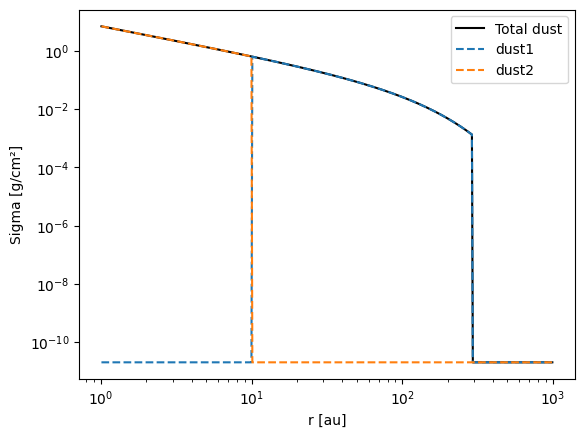

In [23]:
plt.figure()
plt.plot(sim.grid.r/c.au,sim.dust.Sigma.sum(-1),"k",label="Total dust")
plt.plot(sim.grid.r/c.au,sim.components.dust1.dust.Sigma.sum(-1),"--",label="dust1")
plt.plot(sim.grid.r/c.au,sim.components.dust2.dust.Sigma.sum(-1),"--",label="dust2")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r [au]")
plt.ylabel("Sigma [g/cm²]")
plt.legend()

In [24]:
sim.run()


TriPoD v0.0.1

Writing file data/data0000.hdf5
Writing dump file data/frame.dmp
Writing file data/data0001.hdf5
Writing dump file data/frame.dmp
Writing file data/data0002.hdf5
Writing dump file data/frame.dmp
Writing file data/data0003.hdf5
Writing dump file data/frame.dmp
Writing file data/data0004.hdf5
Writing dump file data/frame.dmp
Writing file data/data0005.hdf5
Writing dump file data/frame.dmp
Writing file data/data0006.hdf5
Writing dump file data/frame.dmp
Writing file data/data0007.hdf5
Writing dump file data/frame.dmp
Writing file data/data0008.hdf5
Writing dump file data/frame.dmp
Writing file data/data0009.hdf5
Writing dump file data/frame.dmp
Writing file data/data0010.hdf5
Writing dump file data/frame.dmp
Writing file data/data0011.hdf5
Writing dump file data/frame.dmp
Writing file data/data0012.hdf5
Writing dump file data/frame.dmp
Writing file data/data0013.hdf5
Writing dump file data/frame.dmp
Writing file data/data0014.hdf5
Writing dump file data/frame.dmp
Writing f

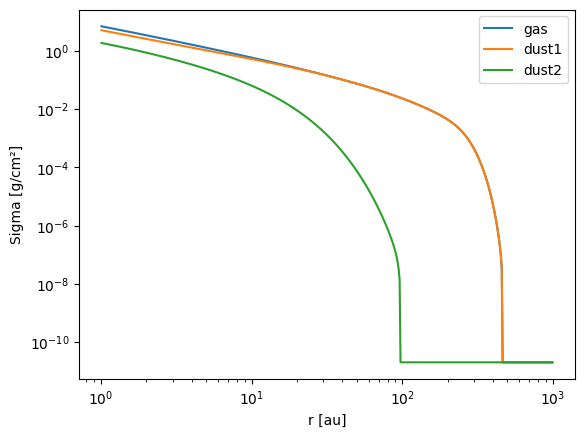

In [26]:
plt.figure()
plt.plot(sim.grid.r/c.au,sim.dust.Sigma.sum(-1),label="gas")

plt.plot(sim.grid.r/c.au,sim.components.dust1.dust.Sigma.sum(-1),label="dust1")
plt.plot(sim.grid.r/c.au,sim.components.dust2.dust.Sigma.sum(-1),label="dust2")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r [au]")
plt.ylabel("Sigma [g/cm²]")
plt.legend()
plt.show()

## Evaporating and Condensating Component

In [ ]:
sim_compo = tripod.Simulation()
sim_compo.ini.grid.rmin = 1 * c.au
sim_compo.ini.grid.rmax = 1000 * c.au
sim_compo.ini.grid.Nr = 500
sim_compo.ini.gas.SigmaRc = 100*c.au
sim_compo.initialize()
sim_compo.t.snapshots = np.linspace(0,1e6*c.year,20)
sim_compo.writer.overwrite = True


dust_value=np.minimum(sim_compo.gas.Sigma*5e-3,sim_compo.dust.Sigma.sum(-1))
dust_value =  dust_value[:,None] * 0.5
# Adds bcakground dust
sim_compo.addcomponent_c("default_dust",sim_compo.gas.SigmaFloor,1,dust_value=sim_compo.dust.Sigma ,dust_active=True, gas_active=False, gas_tracer=False,rhos=sim_compo.dust.rhos[0,0])
#add the CO component
sim_compo.addcomponent_c("CO",sim_compo.gas.SigmaFloor,1,dust_value=dust_value ,dust_active=True, gas_active=True,rhos=1.)

# Set CO parameters for condensation/evaporation
sim_compo.components.CO.gas.pars.mu = 28 * c.m_p
sim_compo.components.CO.gas.pars.nu = 7.0e11
sim_compo.components.CO.gas.pars.Tsub = 1180
sim_compo.components.CO.dust.pars.rhos = 1.0

#update dust internal density -> changed when adding new component
sim_compo.dust.rhos.update()
sim_compo.writer.overwrite = True

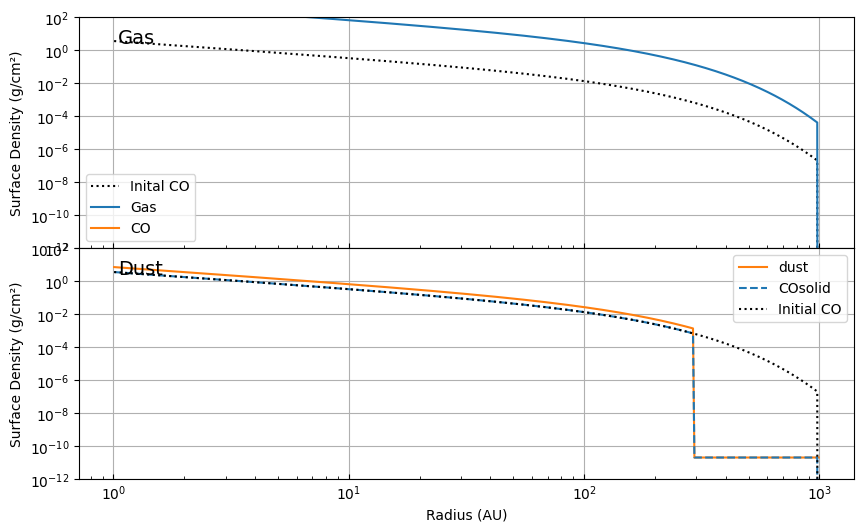

In [ ]:
fg,axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].plot(sim_compo.grid.r/c.au,sim_compo.gas.Sigma*5e-3,"k:", label="Inital CO")

axs[0].plot(sim_compo.grid.r/c.au,sim_compo.components.Default.gas.Sigma,label="Gas")
p = axs[0].plot(sim_compo.grid.r/c.au,sim_compo.components.CO.gas.Sigma,label="CO")

axs[1].plot(sim_compo.grid.r/c.au, sim_compo.components.default_dust.dust.Sigma.sum(-1),color =p[0].get_color(),label="dust")
axs[1].plot(sim_compo.grid.r/c.au, sim_compo.components.CO.dust.Sigma.sum(-1),"--",label="COsolid")


axs[1].plot(sim_compo.grid.r/c.au,sim_compo.gas.Sigma*5e-3,"k:",label='Initial CO')
axs[0].legend()
axs[1].legend()
plt.subplots_adjust(hspace=0)
axs[0].tick_params(axis='x', direction='in')
axs[1].tick_params(axis='x', direction='in')
axs[0].tick_params(axis='x', which='minor', direction='in')
axs[1].tick_params(axis='x', which='minor', direction='in')
axs[0].text(0.05, 0.95, 'Gas', transform=axs[0].transAxes, fontsize=14, verticalalignment='top')
axs[1].text(0.05, 0.95, 'Dust', transform=axs[1].transAxes, fontsize=14, verticalalignment='top')
for ax in axs:
    ax.set_xlabel('Radius (AU)')
    ax.set_ylabel('Surface Density (g/cm²)')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-12, 1e2)
    ax.grid()
plt.show()

In [36]:
sim_compo.run()


TriPoD v0.0.1

Writing file data/data0000.hdf5
Writing dump file data/frame.dmp
Writing file data/data0001.hdf5
Writing dump file data/frame.dmp
Writing file data/data0002.hdf5
Writing dump file data/frame.dmp
Writing file data/data0003.hdf5
Writing dump file data/frame.dmp
Writing file data/data0004.hdf5
Writing dump file data/frame.dmp
Writing file data/data0005.hdf5
Writing dump file data/frame.dmp
Writing file data/data0006.hdf5
Writing dump file data/frame.dmp
Writing file data/data0007.hdf5
Writing dump file data/frame.dmp
Writing file data/data0008.hdf5
Writing dump file data/frame.dmp
Writing file data/data0009.hdf5
Writing dump file data/frame.dmp
Writing file data/data0010.hdf5
Writing dump file data/frame.dmp
Writing file data/data0011.hdf5
Writing dump file data/frame.dmp
Writing file data/data0012.hdf5
Writing dump file data/frame.dmp
Writing file data/data0013.hdf5
Writing dump file data/frame.dmp
Writing file data/data0014.hdf5
Writing dump file data/frame.dmp
Writing f

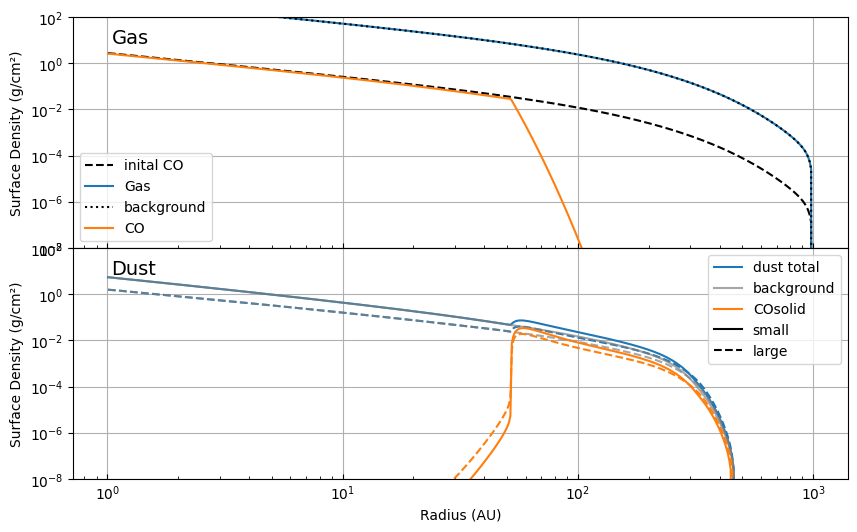

In [37]:
fg,axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].plot(sim_compo.grid.r/c.au,sim_compo.gas.Sigma*5e-3,"k--", label="inital CO")

p1 = axs[0].plot(sim_compo.grid.r/c.au,sim_compo.gas.Sigma,label="Gas")
axs[0].plot(sim_compo.grid.r/c.au,sim_compo.components.Default.gas.Sigma,"k:",label="background")
p = axs[0].plot(sim_compo.grid.r/c.au,sim_compo.components.CO.gas.Sigma,label="CO")

axs[1].plot(sim_compo.grid.r/c.au, sim_compo.dust.Sigma[:,0],"--",color =p1[0].get_color())
axs[1].plot(sim_compo.grid.r/c.au, sim_compo.dust.Sigma[:,1],color =p1[0].get_color(),label="dust total")

axs[1].plot(sim_compo.grid.r/c.au, sim_compo.components.default_dust.dust.Sigma[:,0],"--",color ="gray", alpha =0.7)
axs[1].plot(sim_compo.grid.r/c.au, sim_compo.components.default_dust.dust.Sigma[:,1],color ="gray", alpha =0.7,label="background")

axs[1].plot(sim_compo.grid.r/c.au, sim_compo.components.CO.dust.Sigma[:,0],"--",color =p[0].get_color())
axs[1].plot(sim_compo.grid.r/c.au, sim_compo.components.CO.dust.Sigma[:,1],color =p[0].get_color(),label="COsolid")


#axs[1].plot(sim_compo.grid.r/c.au,sim_compo.gas.Sigma*5e-3,"g:")
axs[1].plot([],[], label='small', color="k")
axs[1].plot([],[], "k--",label='large')
axs[0].legend()
axs[1].legend()
plt.subplots_adjust(hspace=0)
axs[0].tick_params(axis='x', direction='in')
axs[1].tick_params(axis='x', direction='in')
axs[0].tick_params(axis='x', which='minor', direction='in')
axs[1].tick_params(axis='x', which='minor', direction='in')
axs[0].text(0.05, 0.95, 'Gas', transform=axs[0].transAxes, fontsize=14, verticalalignment='top')
axs[1].text(0.05, 0.95, 'Dust', transform=axs[1].transAxes, fontsize=14, verticalalignment='top')
for ax in axs:
    ax.set_xlabel('Radius (AU)')
    ax.set_ylabel('Surface Density (g/cm²)')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-8, 1e2)
    ax.grid()
plt.show()

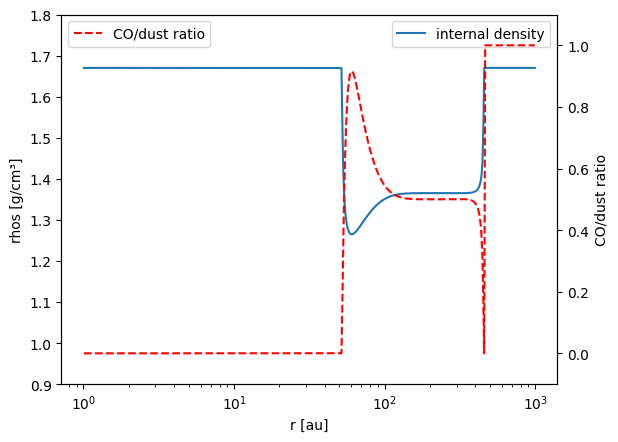

In [38]:
plt.figure()
plt.plot(sim_compo.grid.r/c.au,sim_compo.dust.rhos[:,1],label="internal density")
plt.xscale("log")
plt.ylabel("rhos [g/cm³]")
plt.xlabel("r [au]")
plt.ylim(0.9,1.8)
plt.legend()
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(sim_compo.grid.r/c.au,sim_compo.components.CO.dust.Sigma.sum(-1)/sim_compo.components.default_dust.dust.Sigma.sum(-1),"--",color="r",label="CO/dust ratio")
plt.ylabel("CO/dust ratio")
plt.ylim(-0.1,1.1)
plt.legend()
plt.show()